In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

In [352]:
pd.set_option('display.max_columns', None)

In [353]:
data = pd.read_excel('data/data.xlsx')
blind = pd.read_excel('data/blind_set_new.xlsx')
blind.rename(columns={
    'Client ID': 'client_id', 
    'Loan currency': 'loan_currency', 
    'Loan amount': 'loan_amount',
    'Date of disbursement': 'date_of_disbursement', 
    'Date of closure based on contract':'date_of_closure_based_on_contract', 
    'Duration at disbursement (months)': 'duration_at_disbursement_months',
    'Interest rate': 'interest_rate',
    'Max DPD - 3 year': 'max_dpd_3_year',
    'Cumulative days of late payments throughout loan repayments': 'cumulative_days_of_late_payments_throughout_loan_repayments',
    'Quantity of prior loans (at the time of disbursement at CBI)': 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'Type of product': 'type_of_product',
    'Status of loan': 'status_of_loan',
    'Location': 'location',
    'Emirates': 'emirates',
    'Gender': 'gender',
    'Age': 'age',
    'Family status': 'family_status',
    'Monthly income (AED)': 'monthly_income_aed',
    'Quantity of prior loans at CBI': 'quantity_of_prior_loans_at_cbi',
    'Employment sphere': 'employment_sphere',
    'Employment level': 'employment_level',
    'Work experience': 'work_experience',
    'Presence of car': 'presence_of_car',
    'Presence of housing': 'presence_of_housing',
    'Co-borrower': 'coborrower',
    'Collateral': 'collateral',
    'Top Up': 'top_up',
    'DSR': 'dsr'
    }, inplace=True)


In [354]:
blind.drop(columns=['Education level', "Quantity of client's dependents"], inplace=True)

In [355]:
data = pd.concat([data, blind], ignore_index=True)

In [356]:
data.drop_duplicates(inplace=True)

In [357]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

data['inflation_rate'] = np.zeros(len(data))
data['manufacturing_PMI'] = np.zeros(len(data))

for i in data.index:
    for j in macro.index:
        if data.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            data.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            data.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [359]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

data['CPI'] = [ np.nan for i in data.index]

for i in data.index:
    for j in macro2.index:
        if data.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            data.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [360]:
data_macro = data.copy()

In [361]:
# Creating target columns #
data_macro['max_90_bad'] = (data_macro['max_dpd_3_year'] >= 90).astype(int)
data_macro['cmltv_90_bad'] = (data_macro['cumulative_days_of_late_payments_throughout_loan_repayments'] >= 90).astype(int)

print(data_macro['cmltv_90_bad'].value_counts())

0    3483
1     759
Name: cmltv_90_bad, dtype: int64


In [398]:
target = 'cmltv_90_bad'

cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral',
    'type_of_product',
    'employment_level'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'age',
    'monthly_income_aed',
    'work_experience',
    'inflation_rate',
    'manufacturing_PMI',
    'presence_of_car',
    'presence_of_housing',
    'CPI'
]

ignore_feats = [
    'client_id',
    'loan_currency',
    'date_of_disbursement',
    'date_of_closure_based_on_contract',
    'max_dpd_3_year',
    'cumulative_days_of_late_payments_throughout_loan_repayments',
    'status_of_loan',
    'quantity_of_prior_loans_at_cbi',
    'coborrower',
    'top_up',
    'dsr',
    'max_90_bad'
]

In [363]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in data_macro.index:
    it = data_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    data_macro.at[i, 'work_experience'] = int(years*12 + months)
    
data_macro['work_experience'] = data_macro['work_experience'].astype('float32')

In [364]:
data_macro[data_macro['work_experience'].isna()][['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
85,AED,0.068444,NaN
143,AED,0.080508,NaN
2097,AED,0.045000,NaN
2536,AED,0.120000,NaN
3264,AED,0.100000,NaN


In [365]:
data_macro.family_status = data_macro.family_status.fillna('N/A')
data_macro.work_experience = data_macro.work_experience.fillna(data_macro.inflation_rate.mode())

In [327]:
# data_na = data_macro.dropna(subset=cat_feats+num_feats)

In [366]:
# Choosing only Closed loans & Active loans that are already bad #
data_closed_or_bad = data_macro[(data_macro['status_of_loan'] == 'Active') & (data_macro[target] == 1) | (data_macro['status_of_loan'] != 'Active')]

In [367]:
data_closed_or_bad.drop(columns=["loan_currency"], inplace=True)
ignore_feats.remove('loan_currency')

In [370]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_closed_or_bad, train_size=0.8, random_state=89, stratify=data_closed_or_bad[target])

In [371]:
train.columns

Index(['client_id', 'loan_amount', 'date_of_disbursement',
       'date_of_closure_based_on_contract', 'duration_at_disbursement_months',
       'interest_rate', 'max_dpd_3_year',
       'cumulative_days_of_late_payments_throughout_loan_repayments',
       'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
       'type_of_product', 'status_of_loan', 'location', 'emirates', 'gender',
       'age', 'family_status', 'monthly_income_aed',
       'quantity_of_prior_loans_at_cbi', 'employment_sphere',
       'employment_level', 'work_experience', 'presence_of_car',
       'presence_of_housing', 'coborrower', 'collateral', 'top_up', 'dsr',
       'inflation_rate', 'manufacturing_PMI', 'CPI', 'max_90_bad',
       'cmltv_90_bad'],
      dtype='object')

In [372]:
# Target mean encoding #
cols = cat_feats

for col in cols:
    stats = train[target].groupby(train[col]).agg(['count', 'mean'])
    train[col+'_mean_encoded'] = train[col].copy()
    test[col+'_mean_encoded'] = test[col].copy()
    
    for i in train[col+'_mean_encoded'].unique():
        train[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)        
        test[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)

In [373]:
# Removing classes that are in test set but not in train set #
for i in test.index:
    for col in cat_feats:
        if type(test[col+'_mean_encoded'][i]) == str:
            test.drop(i,inplace=True)
            break

In [374]:
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

cat_feats.clear()

In [375]:
train[train['employment_level'] == 'ADMINISTRATOR'][['employment_level', 'employment_level_mean_encoded']]

,employment_level,employment_level_mean_encoded
3059,ADMINISTRATOR,0.226667
3334,ADMINISTRATOR,0.226667
4746,ADMINISTRATOR,0.226667
2731,ADMINISTRATOR,0.226667
705,ADMINISTRATOR,0.226667
...,...,...
1158,ADMINISTRATOR,0.226667
741,ADMINISTRATOR,0.226667
3875,ADMINISTRATOR,0.226667
828,ADMINISTRATOR,0.226667


In [376]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)

if sorted(all_columns) == sorted(dataset_columns) :
    print( 'All variables are found in feature lists' )
else :
    print('Features found in dataset but not in lists :')
    for i in dataset_columns :
        if i not in all_columns :
            print(i)
    
    print('-'*50)
    print('Features found in lists but not in dataset')
    for i in all_columns :
        if i not in dataset_columns:
            print(i)

All variables are found in feature lists


In [377]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)
sorted(all_columns) == sorted(dataset_columns)

True

In [381]:
exp = ClassificationExperiment()
exp.setup(
    data=train,
    test_data=test,
    target=target,
    index=False,
    fold_shuffle=True,
    
    # categorical_imputation='mode',
    numeric_imputation='mean',
    
    categorical_features=cat_feats,
    numeric_features=num_feats,
    ignore_features=ignore_feats,
    ordinal_features={},

    max_encoding_ohe=70,
    
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    
    use_gpu=False,
    memory=False,

    session_id=2
)

,Description,Value
0,Session id,2
1,Target,cmltv_90_bad
2,Target type,Binary
3,Original data shape,"(3618, 40)"
4,Transformed data shape,"(3618, 20)"
5,Transformed train set shape,"(2908, 20)"
6,Transformed test set shape,"(710, 20)"
7,Ignore features,19
8,Numeric features,20
9,Rows with missing values,11.8%


In [382]:
# train catboost
trained_model_catboost = exp.create_model(
    estimator='catboost',
    iterations=200,
    learning_rate=0.015,
    cross_validation=True,
    return_train_score=True,
    fold=10,
    max_depth = 5,
    # l2_leaf_reg = 3,
    od_type = 'Iter',
    # od_wait = 100,
    random_state = 42
)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [386]:
# train sklearn gbc 
trained_gboosting = exp.create_model(
    estimator='gbc',
    n_estimators=200,
    learning_rate=0.013,
    cross_validation=True,
    return_train_score=True,
    fold=10,
    max_depth = 3,
    random_state = 42
)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [389]:
calibrated_gboosting = exp.calibrate_model(trained_gboosting, fold=10, return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [391]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(calibrated_gboosting, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8423,0.7785,0.3219,0.7833,0.4563,0.3823,0.4343


{'0': {'precision': 0.8775894538606404,
       'recall': 0.8262411347517731,
       'f1-score': 0.8511415525114155,
       'support': 564},
 '1': {'precision': 0.45251396648044695,
       'recall': 0.5547945205479452,
       'f1-score': 0.4984615384615385,
       'support': 146},
 'accuracy': 0.7704225352112676,
 'macro avg': {'precision': 0.6650517101705437,
               'recall': 0.6905178276498591,
               'f1-score': 0.6748015454864771,
               'support': 710},
 'weighted avg': {'precision': 0.7901795649064033,
                  'recall': 0.7704225352112676,
                  'f1-score': 0.7786186200448212,
                  'support': 710},
 'threshold': 0.25,
 'TN': 466,
 'FP': 98,
 'FN': 65,
 'TP': 81,
 'AUC': 0.7785,
 'model NPL': 12.24,
 ' real NPL': 20.56,
 'approval rate': 74.79,
 'good correct': 82.62,
 'bad correct': 55.48}


In [392]:
final_gboosting = exp.finalize_model(calibrated_gboosting)

In [393]:
exp.save_model(final_gboosting, 'gboosting_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['loan_amount',
                                              'duration_at_disbursement_months',
                                              'interest_rate',
                                              'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
                                              'age', 'monthly_income_aed',
                                              'work_experience',
                                              'inflation_rate',
                                              'manufacturing_PMI',
                                              'presence_of_car',
                                              'presence_of_housi...
                                                                                   max_depth=3,
                                                         

In [ ]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(calibrated_catboost, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

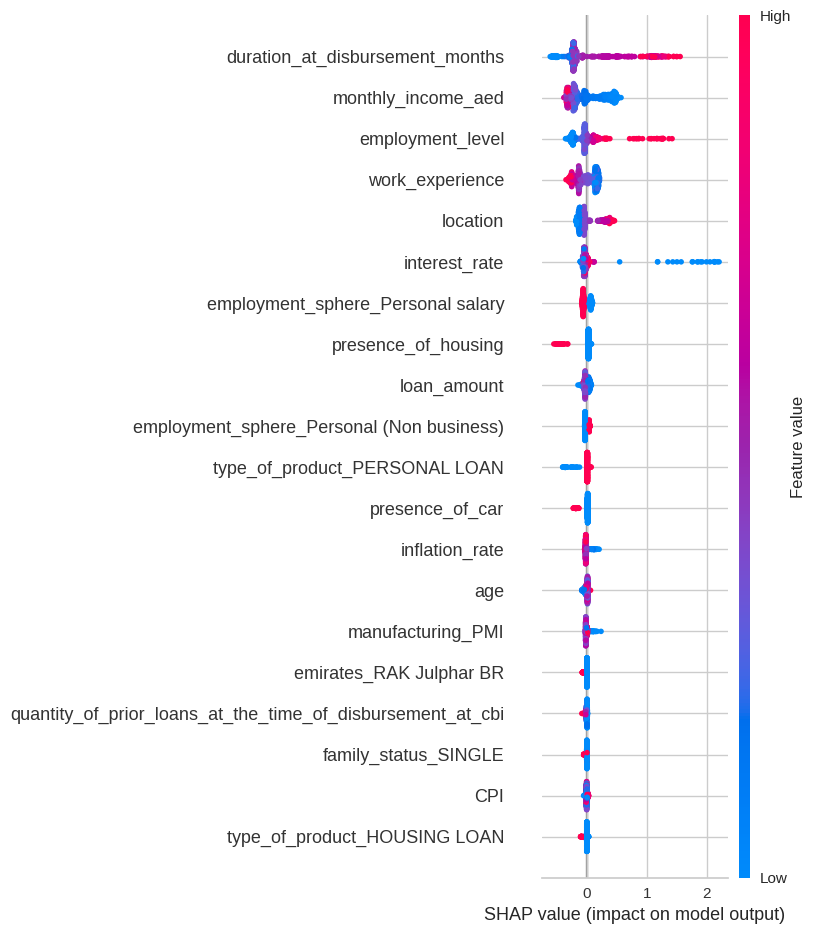

In [163]:
exp.interpret_model(trained_model_catboost)

In [402]:
from create_validator import create_validator

create_validator(data_closed_or_bad[cat_feats + num_feats], 'cmltv_90_bad', 'cbi__variable_validator')

In [ ]:

# best = exp.compare_models(include=['rf', 'xgboost', 'catboost', 'gbc'], fold=5)
# params = {"max_depth": [3,5,6,8,9],
#           "max_features": [3,5,6,7,9],
#           "min_samples_leaf": [2,3,4,5,6],
#           "learning_rate": [0.015, 0.02, 0.05, 0.1]}
# # 
# tuned_boos = exp.tune_model(best, n_iter=200, fold=5, optimize='AUC', custom_grid = params)
# calibrated_boost = exp.calibrate_model(tuned_boos, return_train_score=True)
# calibrated_catboost = exp.calibrate_model(trained_model_catboost, fold=10, return_train_score=True)